# notebook to visualize evaluating sampled antitoxin and GFP sequences

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import os
import math
from collections import Counter
from scipy.sparse.linalg import lsmr
from copy import deepcopy
import tensorflow as tf
print(tf.__version__)
import keras
import importlib
import random

import logomaker

import sys
sys.path.append('../src/')
import covesTools
importlib.reload(covesTools)
import covesTools as ct

import dataTools
importlib.reload(dataTools)
import dataTools as dt

import regressionTools
importlib.reload(regressionTools)
import regressionTools as rt

### get the right plt style
plt.style.use('../src/paper_style1.mplstyle')

## adding the arial font that had to be downloaded
# following this: https://betterdatascience.com/python-matplotlib-fonts/
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ['../src/fonts/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

font_manager.findfont('arial') # font_manager.findfont('Arial') doesn't work
from matplotlib import rcParams
rcParams['font.family'] = 'arial'


2.7.0


In [2]:
dout ='../data/out/'


# AT 10 position sampled sequence evaluation

In [1]:
! pwd

/n/groups/marks/users/david/github/CoVES/coves


In [2]:
sample_din_at_coves = '../data/coves/samples/at/'

pmpnn_dir_at = '../other_tools/protein_mpnn/samples/at_samples/'
esm_dir_at = '../other_tools/esm/samples/at_samples/'
evc_dir_at = '../other_tools/evc/samples/t_screen/'

## get the supervised oracle function

(201, 1)
layer0 weights set to:  [[ 0.01701156]
 [-0.01035653]
 [ 0.03116564]
 [ 0.00747865]
 [-0.03876103]]
beta_hat [ 0.01701156 -0.01035653  0.03116564  0.00747865 -0.03876103]


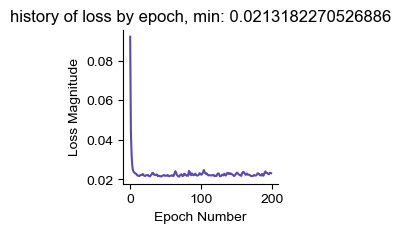

In [162]:
# get the supervised oracle
x,y,df_at_10p = dt.get_x_y_at_10p()
model_10p, history, callbacks = rt.fit_log_model(
    x,y, 
    my_layer=rt.log_layer(1), # do not scale, just predict between 0 and 1
    adam_lr =0.1, 
    epochs=200,
    batch_size=1000)

## load antitoxin generated sequences

In [163]:
random.seed(42)
live_thresh = 0.5 # threshold for considering a variant functional
model = model_10p # which oracle model to use
deduplicate = True # whether to deduplicate the sampled sequences
n_unique_seq_sample = 30 # number of sequences to downsample to
n_downsampling = 10 # how many times to downsample

## read coves generated sequences

In [190]:
# read in coves sampled sequences
# deduplicates sampled sequences
# downsamples sampled sequences to match approximately 
# the number of generated sequence from proteinMPNN, for which ~ 30 seqs were sampled only

mean_hamming_pw_coves = []
mean_hamming_wt_coves = []
frac_alive_coves = []
for t in [0.1, 0.5,0.7,1,1.5,2,2.25,2.5,2.75,3,4,5]:
    fin = sample_din_at_coves+'gvp_100_m_RES_1646945484_3030427_8_220711_samples_t{}_n500.csv'.format(t)
    for i in range(n_downsampling):
        mutkeys = rt.read_sampled_mut_key(fin) # getting the mutkeys
        if deduplicate:
            mutkeys = list(set(mutkeys))
        #sample down to match the number of sequences generated by proteinMPNN
        mutkeys = random.choices(mutkeys, k=n_unique_seq_sample)
        
        # make a list of mutated sequence considering only the 10 mutated positions
        list_mutseqs = rt.get_muts_from_mutkeys(mutkeys)

        # calculate statistics
        frac_alive,mean_pw_hamming,mean_wt_hamming = rt.calc_at_sample_stats(list_mutseqs, model, live_thresh)
        
        #collect
        frac_alive_coves.append(frac_alive)
        mean_hamming_pw_coves.append(mean_pw_hamming)
        mean_hamming_wt_coves.append(mean_wt_hamming)
    

## read proteinMPNN generated sequences

In [175]:
# read in proteinMPNN sampled sequences

mean_hamming_pw_pmpnn = []
mean_hamming_wt_pmpnn = []
frac_alive_pmpnn = []

pmpnn_files_consider = [f for f in listdir(pmpnn_dir_at) if f.split('_')[2]=='n30']

m0_pos_10x = [int(m[1:])-1 for m in rt.list_wtaa_pos]

for f in sorted(pmpnn_files_consider):
    # collect all mutants for a file
    list_muts = [] # list of mutations ['EERK', ] per sequence

    for r in rt.fasta_iter_py3(pmpnn_dir_at + f):
        gen_seq = r.sequence
        one_seq_muts = rt.get_muts_from_fl_sampled_seq(gen_seq,m0_pos_10x, wt_chain= rt.wt_chain_a) # get the right positions
        list_muts.append(''.join(one_seq_muts))
        
    if deduplicate:
        n_before_dedup = len(list_muts)
        list_muts = list(set(list_muts))
        n_after_dedup = len(list_muts)
    
    # calculate statistics
    frac_alive,mean_pw_hamming,mean_wt_hamming = rt.calc_at_sample_stats(list_muts, model, threshold)

    frac_alive_pmpnn.append(frac_alive)
    mean_hamming_pw_pmpnn.append(np.mean(mean_pw_hamming))
    mean_hamming_wt_pmpnn.append(np.mean(mean_wt_hamming))


## read ESM-IF generated sequences

In [178]:
# for ESM gen seqs

t_esm = [0.75, 1.25, 1.5, 1.75, 2.0, 3.0, 4.0, 5.0]
m0_pos_10x = [int(m[1:])-1 for m in rt.list_wtaa_pos]

frac_alive_esm =[]
mean_hamming_pw_esm = []
mean_hamming_wt_esm = []

p = 10
for t in t_esm:
    for i in range(n_downsampling):
        df_esm_gen = pd.read_csv(esm_dir_at + 'esm_t{}_pos{}_n100_gen_seq.csv'.format(t, p), header=None)
        df_esm_gen = df_esm_gen.rename(columns={0:'seq'})
        df_esm_gen['has_weird_chars'] = df_esm_gen.apply(lambda r: ('<' in r.seq) or ('B' in r.seq), axis=1)
        df_esm_gen_clean = deepcopy(df_esm_gen[~df_esm_gen.has_weird_chars])
        
        df_esm_gen_clean['muts'] = df_esm_gen_clean.apply(
            lambda r: ''.join(rt.get_muts_from_fl_sampled_seq(r.seq,m0_pos_10x)), axis=1)
        if deduplicate:
            muts = list(set(df_esm_gen_clean['muts']))
            # downsample to match proteinMPNN numbers approximately
            list_muts = random.choices(muts, k=n_unique_seq_sample)
        else:
            list_muts = list(df_esm_gen_clean['muts'].values)

        # calculate statistics
        frac_alive,mean_pw_hamming,mean_wt_hamming = rt.calc_at_sample_stats(list_muts, model, threshold)

        frac_alive_esm.append(frac_alive)
        mean_hamming_pw_esm.append(np.mean(mean_pw_hamming))
        mean_hamming_wt_esm.append(np.mean(mean_wt_hamming))

## evcouplings generated sequences

In [179]:
# for evcouplings gen seqs
frac_alive_evc =[]
mean_hamming_pw_evc = []
mean_hamming_wt_evc = []

p = 10
fs = [f for f in listdir(evc_dir_at) if f.endswith('.csv')]
for f in fs:
    for i in range(n_downsampling):
        df_evc_gen = pd.read_csv(evc_dir_at + f, index_col=0)
        df_evc_gen.loc[:,'muts_only'] = df_evc_gen.apply(lambda r: ''.join([v[-1] for v in r.full_mut.split(':')]), axis=1)

        # get deduplicated individual mutants
        muts = list(df_evc_gen['muts_only'])
        if deduplicate:
            muts = list(set(muts))
            # downsample to match proteinMPNN numbers approximately
            list_muts = random.choices(muts, k=n_unique_seq_sample)
        else:
            list_muts = list(df_evc_gen['muts'].values)

        # calculate statistics
        frac_alive,mean_pw_hamming,mean_wt_hamming = rt.calc_at_sample_stats(list_muts, model, threshold)

        frac_alive_evc.append(frac_alive)
        mean_hamming_pw_evc.append(np.mean(mean_pw_hamming))
        mean_hamming_wt_evc.append(np.mean(mean_wt_hamming))
        

## making random samples from dataframe

In [180]:
# make random samples from the observed df
rand_seed = 42
np.random.seed(rand_seed)

def sample_biased_df_penalized_hamming(df, bias_scale=1, rand_seed = 42):
    np.random.seed(rand_seed)
    # higher more bias towards low hamming distance sequences
    # df needs a column 'hamming' to weight by
    idx_to_sample = list(range(len(df)))
    f_samples = [10**(-int(v)*bias_scale) for v in df.hamming]
    p_samples = np.array(f_samples)/math.fsum(f_samples)
    #print(p_samples)

    random_row_idxs = np.random.choice(idx_to_sample, n_unique_seq_sample, p=p_samples)
    random_row_idxs
    df_sample = df.iloc[random_row_idxs]
    return df_sample


df_at_10p['muts_only'] = df_at_10p.apply(lambda r: ''.join([v[-1] for v in r.muts.split(':')]), axis=1)

frac_alive_pw_random =[]
mean_hamming_pw_random = []
mean_hamming_wt_random = []

for i in range(n_downsampling):
    for bias_scale in [-0.5,0,0.3,0.5, 0.7, 1, 1.5]:
        df_sample = sample_biased_df_penalized_hamming(df_at_10p, 
                                                       bias_scale=bias_scale, 
                                                       rand_seed = np.random.randint(100))

        list_muts = list(set(df_sample['muts_only']))
        # calculate statistics
        frac_alive,mean_pw_hamming,mean_wt_hamming = rt.calc_at_sample_stats(list_muts, model, threshold)
       
        frac_alive_pw_random.append(frac_alive)
        mean_hamming_pw_random.append(mean_pw_hamming)
        mean_hamming_wt_random.append(mean_wt_hamming)
        

## sampling using the logistic regression weights of the oracle --> Does the oracle believe there are more good sequences out there?

In [181]:
# generate sequences using learned log regression weights

# get the weights of the logistic regression
model_w_10p = model_10p.get_weights()[0]
model_10_p_aa_pref = model_w_10p[:200,:]
model_10_p_aa_pref= model_10_p_aa_pref.reshape(20,-1,order='F') # reshape in fortran order, this is important here, otherwise they get mixed up weird.

random.seed(3)

n_sample = n_unique_seq_sample
t_sample = [0.5, 0.7, 0.8, 0.9, 1, 1.5, 2, 3,5]
t_to_sampled_muts = {}

for t in t_sample:
    list_combi_mutkeys = []
    for i in range(n_sample):
        list_one_combi_muts = []
        for p in range(10):
            scores = model_10_p_aa_pref[:,p]
            scores_shift = scores - np.max(scores) # need to shift these, since the scores can be below and above 0, and that does not work for get_norm_prob
            sampled_aa = ct.sample_aa_gvp_pos_boltz(rt.AA_ALPHABET, 
                                                    scores_shift, 
                                                    t=t, 
                                                    n_sample = 1, 
                                                    rand_seed=random.randint(0, 100))
            list_one_combi_muts.append(sampled_aa[0])

        list_combi_mutkeys.append(''.join(list_one_combi_muts))
    t_to_sampled_muts[t] = list_combi_mutkeys


In [183]:
#
frac_alive_lr =[]
mean_hamming_pw_lr = []
mean_hamming_wt_lr = []

for t in t_sample:
    for i in range(n_sample):
        list_muts = t_to_sampled_muts[t]
        
        if deduplicate:
            list_muts = list(set(list_muts))
            # downsample to match proteinMPNN numbers approximately
            list_muts = random.choices(list_muts, k=n_unique_seq_sample)
        # calculate statistics
        frac_alive,mean_pw_hamming,mean_wt_hamming = rt.calc_at_sample_stats(list_muts, model, threshold)

        frac_alive_lr.append(frac_alive)
        mean_hamming_pw_lr.append(mean_pw_hamming)
        mean_hamming_wt_lr.append(mean_wt_hamming)


## plot 

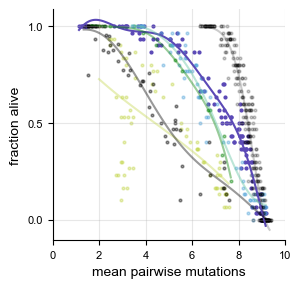

In [184]:

def plot_polyline(x_in, y_in, 
                  order=8, 
                  fixed_points=([0,1, 10],[1,1, 0]),
                    color = 'black', 
                  alpha=1
                 ):

    x,y = fixed_points[0]+x_in, fixed_points[1]+y_in
    polyf = np.poly1d(np.polyfit(x,y, order))
    xp = np.linspace(min(x_in),max(x_in), 100)
    plt.plot(xp, polyf(xp), color=color, alpha=alpha)


alpha=0.4
ms = 4
plot_lw = 1
fig= plt.figure(figsize=(3,3))

#coves
plt.scatter(mean_hamming_pw_coves, frac_alive_coves, label='coves', alpha=1, s=ms)
plot_polyline(mean_hamming_pw_coves, frac_alive_coves, color = '#5B49B6', alpha=1)

#pmpnn
plt.scatter(mean_hamming_pw_pmpnn, frac_alive_pmpnn, label ='pMPNN', color = 'green',alpha=alpha, s=ms)
plot_polyline(mean_hamming_pw_pmpnn, frac_alive_pmpnn, color = 'green', alpha=alpha)

# esm
plt.scatter(mean_hamming_pw_esm, frac_alive_esm, label ='esm IF', alpha=alpha, s=ms)
plot_polyline(mean_hamming_pw_esm, frac_alive_esm, color= '#59C09D', alpha=alpha)

# evc
plt.scatter(mean_hamming_pw_evc, frac_alive_evc, label ='evC', color = '#C3D64C', alpha=alpha, s=ms)
plot_polyline(mean_hamming_pw_evc, frac_alive_evc, order = 3, color= '#C3D64C', alpha=alpha)

# random
plt.scatter(mean_hamming_pw_random, frac_alive_pw_random, label ='random', color = 'black', alpha=alpha, s=ms)
plot_polyline(mean_hamming_pw_random, frac_alive_pw_random, color= 'black', alpha=alpha, order=6)

# supervised
plt.scatter(mean_hamming_pw_lr, frac_alive_lr, label ='supervised', color='black', alpha=0.2, s=ms)
plot_polyline(mean_hamming_pw_lr, frac_alive_lr, order = 10,color= 'black', alpha=0.2, 
              fixed_points = ([0,1,2,3,4,5, 10],[1,1,1,1,1,1,0]))

plt.xlim([0,10])
#plt.legend(loc='center left', fontsize=8)
plt.xticks(list(range(11)))
plt.xticks([0,2,4,6,8,10], size=8)
plt.yticks([0,0.5,1], size=8)

#plt.legend()
plt.xlabel('mean pairwise mutations')
plt.ylabel('fraction alive')
#plt.title('pairwise hamming vs. fraction alive')
plt.grid(alpha=0.3)
fig.patch.set_visible(False)
plt.savefig(dout + 'frac_alive_vs_hamm_pw_renorm_dedup_res_sample_down_n10down.svg', format='svg')
plt.show()

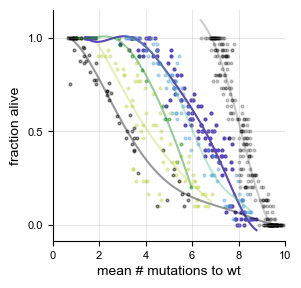

In [168]:
# plotting the average number of mutations to WT vs. function
fig= plt.figure(figsize=(3,3))

# coves
plt.scatter(mean_hamming_wt_coves, frac_alive_res, label='RES', alpha=1, s=ms)
plot_polyline(mean_hamming_wt_coves, frac_alive_res, color = '#5B49B6', alpha=1)
# pmpnn
plt.scatter(mean_hamming_wt_pmpnn, frac_alive_pmpnn, label ='pMPNN', color = 'green',  alpha=alpha, s=ms)
plot_polyline(mean_hamming_wt_pmpnn, frac_alive_pmpnn, color = 'green', alpha=alpha)

# esm
plt.scatter(mean_hamming_wt_esm, frac_alive_esm, label ='esm IF', alpha=alpha, s=ms)
plot_polyline(mean_hamming_wt_esm, frac_alive_esm, color = '#59C09D', alpha=alpha)

#evc
plt.scatter(mean_hamming_wt_evc, frac_alive_evc, label ='evC',color = '#C3D64C', alpha=alpha, s=ms)
plot_polyline(mean_hamming_wt_evc, frac_alive_evc, order=5, color = '#C3D64C', alpha=alpha)

# random
plt.scatter(mean_hamming_wt_random, frac_alive_pw_random, label ='random', color = 'black',alpha=alpha, s=ms)
plot_polyline(mean_hamming_wt_random, frac_alive_pw_random, order=5, color = 'black', alpha=alpha)

# supervised
plt.scatter(mean_hamming_wt_lr, frac_alive_lr, label ='supervised', color='black', alpha=0.2, s=ms)
plot_polyline(mean_hamming_wt_lr, frac_alive_lr, order = 6,color = 'black', alpha=0.2,
              fixed_points = ([0,1,2,3,4,5, 10],[1,1,1,1,1,1,0])
             )


#plt.legend(loc='center left', fontsize = 8)
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], size=8)
plt.yticks([0,0.5,1], size=8)

plt.xlabel('mean # mutations to wt')
plt.ylabel('fraction alive')
#plt.legend()
#plt.title('hamming to wt vs. fraction alive')
plt.grid(alpha=0.3)
fig.patch.set_visible(False)
plt.savefig(dout + 'frac_alive_vs_hamm_wt_renorm_dedup_res_sample_down_n10down.svg', format='svg')
plt.show()

## plotting the sequence logos of generated sequences


,M,K,Q,A,R,V,T,W,E,C,I,H,S,N,G,L,D,F,Y,P
1,17.0,20.0,8.0,6.0,20.0,3.0,4,1.0,1.0,1,3.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0,2.0,8.0,0.0,0.0,79.0,0.0,0.0,0.0
3,4.0,1.0,3.0,1.0,7.0,27.0,4,1.0,4.0,3,14.0,1.0,1.0,4.0,1.0,7.0,1.0,3.0,3.0,1.0
4,3.0,20.0,6.0,4.0,26.0,4.0,6,0.0,2.0,1,1.0,1.0,1.0,1.0,1.0,3.0,2.0,3.0,6.0,0.0
5,12.0,1.0,2.0,1.0,2.0,1.0,1,2.0,0.0,3,0.0,1.0,1.0,2.0,0.0,58.0,0.0,2.0,2.0,0.0
6,1.0,1.0,1.0,0.0,1.0,5.0,2,2.0,3.0,2,8.0,1.0,1.0,1.0,0.0,4.0,0.0,38.0,20.0,0.0
7,3.0,24.0,4.0,0.0,49.0,1.0,3,0.0,1.0,2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8,5.0,6.0,14.0,8.0,6.0,5.0,3,1.0,28.0,1,2.0,2.0,1.0,1.0,0.0,2.0,3.0,1.0,2.0,0.0
9,0.0,0.0,0.0,72.0,0.0,0.0,2,0.0,0.0,4,0.0,0.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,4.0,40.0,3.0,0.0,32.0,3.0,1,0.0,1.0,3,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


/tmp/ipykernel_9402/1567460417.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  lm.ax.set_yticklabels([0,25,50,75],size=7)


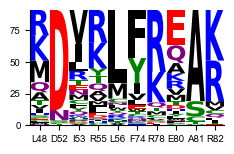

In [10]:
df_t15 = pd.read_csv(sample_din_at_coves+'gvp_100_m_RES_1646945484_3030427_8_220711_samples_t1.5_n500.csv', header=None)

# deduplicate
all_gen_muts = set(df_t15[0])
# creating a position by amino acid df
list_of_dics=[]
for p in range(10):
    muts = [mut.split(':')[p][-1] for mut in all_gen_muts]
    list_of_dics.append(Counter(muts))
df_counts = pd.DataFrame(list_of_dics)
df_counts.index = range(1,11)
df_counts = df_counts.fillna(0)

display(df_counts)
lm = logomaker.Logo(df_counts, color_scheme='chemistry', 
                    figsize= (2.5,1.5))
lm.ax.set_xticks(range(1,11))
lm.ax.set_xticklabels(list_wtaa_pos, size=7)
lm.ax.set_yticklabels([0,25,50,75],size=7)

plt.savefig(dout + 'logo_gen_seq_n500_t15.svg', format='svg')

# GFP: evaluate sampled sequences from CoVES, ESM-IF, proteinMPNN
- 

In [3]:
sample_din_gfp_coves = '../data/coves/samples/gfp/'

# do not call these mutations since they are the difference between pdb sequence and experimental sequence
list_muts_dms_exclude = ['R80Q','T167I','N238K'] 

# fetch experimental data
fin_gfp_exp = '../data/DMS_data/gfp_data.csv'
df_gfp = pd.read_csv(fin_gfp_exp, index_col = 0)

# find the half-maximal DMS score
threshold = (max(df_gfp.DMS_score) - min(df_gfp.DMS_score))/2 + min(df_gfp.DMS_score)
print(threshold)

# calculate how many individual mutants seen
muts_seen_dms = set([ind_m for m in df_gfp.mutant for ind_m in m.split(':') ])
print(len(muts_seen_dms))
print(len(set([m[1:-1] for m in muts_seen_dms])))

# calculate how many variants seen per mutation distance, and how many variants achieve the half-maximal DMS score threshold
wt_gfp_seq_dms = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'
df_gfp['hamming_wt'] = df_gfp.mutated_sequence.apply(lambda x: rt.hamming(wt_gfp_seq_dms,x))

list_hamming_obs = []
list_fraction_alive_obs = []
for n_muts in sorted(list(set(df_gfp.hamming_wt))):
    df_gfp_n_hamm = df_gfp.loc[df_gfp.hamming_wt == n_muts]
    print(n_muts, len(df_gfp_n_hamm))
    f_alive = sum(df_gfp_n_hamm.DMS_score > threshold)/len(df_gfp_n_hamm)
    list_fraction_alive_obs.append(f_alive)
    list_hamming_obs.append(n_muts)


2.7032641513550004
1810
233
1 1084
2 12777
3 12336
4 9387
5 6825
6 4298
7 2526
8 1364
9 627
10 299
11 118
12 43
13 23
14 5
15 2


(51714, 4761)


2023-06-21 17:29:36.380282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/app/gcc/6.2.0/lib64:/n/app/gcc/6.2.0/lib
2023-06-21 17:29:36.380370: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-21 17:29:36.380408: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (compute-a-16-166.o2.rc.hms.harvard.edu): /proc/driver/nvidia/version does not exist
2023-06-21 17:29:36.380987: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(4761, 1)
layer0 weights set to:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
beta_hat [0. 0. 0. 0. 0.]


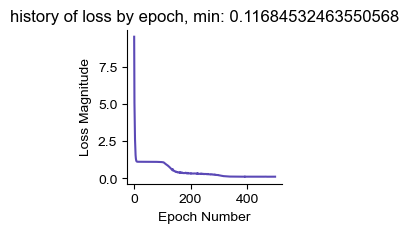

In [4]:
# train the scaled logistic regression

# fetch x,y
df_gfp['oh_code'] = df_gfp.apply(lambda r: rt.seq_to_oh(r.mutated_sequence, rt.aa_to_idx), axis=1)
X = np.stack(list(df_gfp['oh_code'].values), axis=0)
X= np.c_[X,np.ones(X.shape[0])]
print(X.shape)
Y = df_gfp.DMS_score.values

model, history, callbacks = rt.fit_log_model(X, Y, 
                                        my_layer=rt.log_layer_scale_shift(1, reg_strength=0),
                                        adam_lr =0.005,
                                         epochs=500,
                                         batch_size=1000, 
                                         rand_seed=3)

Yhat_non= model.predict(X).flatten()
df_gfp['nonlinear_predict'] = Yhat_non


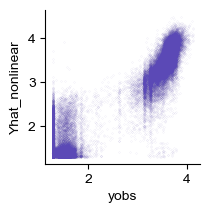

In [13]:
# double check training worked
plt.figure(figsize=(2,2))
plt.scatter(Y, Yhat_non, s=0.001)
plt.xlabel('yobs')
plt.ylabel('Yhat_nonlinear')
plt.show()

## reading COVES samples in

In [15]:
sample_din = '../data/coves/samples/gfp/'

df_coves_sampling_results_all = dt.collate_gfp_sampling_results_coves(sample_din, 
                                                               model, 
                                                               muts_seen_dms, 
                                                               wt_gfp_seq_dms, 
                                                               threshold,
                                                               suffix_filter='230528.csv', 
                                                               suffix_exclude = '.txt')

95
reading f with t1.0, n_sample300, n_pos_mutate8
286
reading f with t1.0, n_sample300, n_pos_mutate13
289
reading f with t0.5, n_sample300, n_pos_mutate17
286
reading f with t1.0, n_sample300, n_pos_mutate14
278
reading f with t1.0, n_sample300, n_pos_mutate16
284
reading f with t10.0, n_sample300, n_pos_mutate15
285


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t2.0, n_sample300, n_pos_mutate9
285
reading f with t2.5, n_sample300, n_pos_mutate10
279
reading f with t0.7, n_sample300, n_pos_mutate10
288
reading f with t0.6, n_sample300, n_pos_mutate10
285
reading f with t2.5, n_sample300, n_pos_mutate13
289
reading f with t0.5, n_sample300, n_pos_mutate16
282
reading f with t1.0, n_sample300, n_pos_mutate11
287
reading f with t2.0, n_sample300, n_pos_mutate14
279
reading f with t2.0, n_sample300, n_pos_mutate10
278
reading f with t3.0, n_sample300, n_pos_mutate15
283
reading f with t1.0, n_sample300, n_pos_mutate9
288
reading f with t0.6, n_sample300, n_pos_mutate5
281
reading f with t2.5, n_sample300, n_pos_mutate9
284
reading f with t0.5, n_sample300, n_pos_mutate6
284
reading f with t0.5, n_sample300, n_pos_mutate10
285
reading f with t0.3, n_sample300, n_pos_mutate5
285
reading f with t1.0, n_sample300, n_pos_mutate15
280
reading f with t3.0, n_sample300, n_pos_mutate7
277
reading f with t2.0, n_sample300, n_pos_mutate11
287


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t1.0, n_sample300, n_pos_mutate19
285


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t1.0, n_sample300, n_pos_mutate5
287
reading f with t0.5, n_sample300, n_pos_mutate19
288
reading f with t4.0, n_sample300, n_pos_mutate10
284
reading f with t3.0, n_sample300, n_pos_mutate12
288
reading f with t3.0, n_sample300, n_pos_mutate8
286
reading f with t3.0, n_sample300, n_pos_mutate13
288
reading f with t3.0, n_sample300, n_pos_mutate5
282
reading f with t2.5, n_sample300, n_pos_mutate11
289
reading f with t4.0, n_sample300, n_pos_mutate15
284


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t2.5, n_sample300, n_pos_mutate15
291
reading f with t0.5, n_sample300, n_pos_mutate15
280
reading f with t0.5, n_sample300, n_pos_mutate8
280
reading f with t2.5, n_sample300, n_pos_mutate14
289
reading f with t0.1, n_sample300, n_pos_mutate5
282
reading f with t20.0, n_sample300, n_pos_mutate15
278


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t0.1, n_sample300, n_pos_mutate15
280
reading f with t2.0, n_sample300, n_pos_mutate12
281
reading f with t0.5, n_sample300, n_pos_mutate7
285
reading f with t2.0, n_sample300, n_pos_mutate7
284
reading f with t20.0, n_sample300, n_pos_mutate10
288
reading f with t0.5, n_sample300, n_pos_mutate5
284
reading f with t2.0, n_sample300, n_pos_mutate5
284
reading f with t10.0, n_sample300, n_pos_mutate10
282
reading f with t0.7, n_sample300, n_pos_mutate15
282
reading f with t0.5, n_sample300, n_pos_mutate20
284
reading f with t0.5, n_sample300, n_pos_mutate18
283
reading f with t8.0, n_sample300, n_pos_mutate15
278


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t2.5, n_sample300, n_pos_mutate6
286
reading f with t20.0, n_sample300, n_pos_mutate5
287
reading f with t5.0, n_sample300, n_pos_mutate5
291
reading f with t3.0, n_sample300, n_pos_mutate9
282
reading f with t0.5, n_sample300, n_pos_mutate13
271
reading f with t0.5, n_sample300, n_pos_mutate11
286
reading f with t8.0, n_sample300, n_pos_mutate5
288
reading f with t3.0, n_sample300, n_pos_mutate10
285
reading f with t0.4, n_sample300, n_pos_mutate5
284
reading f with t0.3, n_sample300, n_pos_mutate15
289
reading f with t0.6, n_sample300, n_pos_mutate15
277
reading f with t3.0, n_sample300, n_pos_mutate14
284
reading f with t0.5, n_sample300, n_pos_mutate14
283
reading f with t3.0, n_sample300, n_pos_mutate6
289
reading f with t0.7, n_sample300, n_pos_mutate5
287
reading f with t2.0, n_sample300, n_pos_mutate6
289
reading f with t2.5, n_sample300, n_pos_mutate12
285
reading f with t1.0, n_sample300, n_pos_mutate7
283
reading f with t0.3, n_sample300, n_pos_mutate10
277
re

/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t0.1, n_sample300, n_pos_mutate10
292
reading f with t1.0, n_sample300, n_pos_mutate6
287
reading f with t0.4, n_sample300, n_pos_mutate15
281
reading f with t1.0, n_sample300, n_pos_mutate17
285
reading f with t0.5, n_sample300, n_pos_mutate12
283
reading f with t2.0, n_sample300, n_pos_mutate8
287
reading f with t2.0, n_sample300, n_pos_mutate15
282
reading f with t8.0, n_sample300, n_pos_mutate10
288


## read ESM generation files in:

In [29]:
esm_dout_samples = "../other_tools/esm/samples/gfp_samples/"

df_result_esm_all = dt.collate_gfp_sampling_results_esm(esm_dout_samples, 
                                               model, 
                                               muts_seen_dms, 
                                               wt_gfp_seq_dms,
                                               list_muts_dms_exclude, # list of mutations
                                               threshold,
                                               suffix_filter='.csv')

reading f with t3.0, n_sample400, n_pos_mutate5
reading f with t0.5, n_sample400, n_pos_mutate11
reading f with t0.001, n_sample400, n_pos_mutate10
reading f with t2.0, n_sample400, n_pos_mutate10
reading f with t5.0, n_sample400, n_pos_mutate10
reading f with t30.0, n_sample400, n_pos_mutate5
reading f with t0.1, n_sample400, n_pos_mutate5
reading f with t1.75, n_sample400, n_pos_mutate5
reading f with t10.0, n_sample400, n_pos_mutate15
reading f with t1.75, n_sample400, n_pos_mutate10


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t1.25, n_sample400, n_pos_mutate15
reading f with t4.0, n_sample400, n_pos_mutate10
reading f with t5.0, n_sample400, n_pos_mutate5
reading f with t0.75, n_sample400, n_pos_mutate19


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t1000.0, n_sample400, n_pos_mutate10
reading f with t0.75, n_sample400, n_pos_mutate10
reading f with t1000.0, n_sample400, n_pos_mutate5
reading f with t1.0, n_sample400, n_pos_mutate17
reading f with t1.0, n_sample400, n_pos_mutate11
reading f with t80.0, n_sample400, n_pos_mutate5
reading f with t1.0, n_sample400, n_pos_mutate7
reading f with t0.75, n_sample400, n_pos_mutate15
reading f with t0.5, n_sample400, n_pos_mutate9
reading f with t0.75, n_sample400, n_pos_mutate7
reading f with t20.0, n_sample400, n_pos_mutate10
reading f with t3.0, n_sample400, n_pos_mutate15
reading f with t0.75, n_sample400, n_pos_mutate17
reading f with t0.5, n_sample400, n_pos_mutate7
reading f with t0.75, n_sample400, n_pos_mutate5
reading f with t4.0, n_sample400, n_pos_mutate15


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t100.0, n_sample400, n_pos_mutate10
reading f with t200.0, n_sample400, n_pos_mutate10
reading f with t80.0, n_sample400, n_pos_mutate10
reading f with t0.1, n_sample400, n_pos_mutate15
reading f with t1.5, n_sample400, n_pos_mutate5
reading f with t0.1, n_sample400, n_pos_mutate10
reading f with t0.5, n_sample400, n_pos_mutate19


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t10.0, n_sample400, n_pos_mutate5
reading f with t200.0, n_sample400, n_pos_mutate5
reading f with t100.0, n_sample400, n_pos_mutate5
reading f with t0.01, n_sample400, n_pos_mutate15
reading f with t0.75, n_sample400, n_pos_mutate9
reading f with t70.0, n_sample400, n_pos_mutate5
reading f with t1.75, n_sample400, n_pos_mutate15
reading f with t1.0, n_sample400, n_pos_mutate15
reading f with t0.5, n_sample400, n_pos_mutate15
reading f with t1.25, n_sample400, n_pos_mutate5
reading f with t0.01, n_sample400, n_pos_mutate5
reading f with t4.0, n_sample400, n_pos_mutate5
reading f with t40.0, n_sample400, n_pos_mutate10
reading f with t0.75, n_sample400, n_pos_mutate13
reading f with t1.0, n_sample400, n_pos_mutate10
reading f with t2.0, n_sample400, n_pos_mutate15
reading f with t0.5, n_sample400, n_pos_mutate13
reading f with t20.0, n_sample400, n_pos_mutate5
reading f with t70.0, n_sample400, n_pos_mutate10
reading f with t0.001, n_sample400, n_pos_mutate5
reading f wit

/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t3.0, n_sample400, n_pos_mutate10
reading f with t0.01, n_sample400, n_pos_mutate10
reading f with t5.0, n_sample400, n_pos_mutate15


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t30.0, n_sample400, n_pos_mutate10
reading f with t2.0, n_sample400, n_pos_mutate5
reading f with t10.0, n_sample400, n_pos_mutate10
reading f with t1.0, n_sample400, n_pos_mutate13
reading f with t1.0, n_sample400, n_pos_mutate9
reading f with t1.5, n_sample400, n_pos_mutate10
reading f with t0.5, n_sample400, n_pos_mutate5
reading f with t0.75, n_sample400, n_pos_mutate11
reading f with t1.25, n_sample400, n_pos_mutate10
reading f with t1.5, n_sample400, n_pos_mutate15
reading f with t0.5, n_sample400, n_pos_mutate17
reading f with t1.0, n_sample400, n_pos_mutate5
reading f with t40.0, n_sample400, n_pos_mutate5


# read proteinMPNN generated samples in

In [31]:
mpnn_dout_samples = '../other_tools/protein_mpnn/samples/gfp_samples/'

df_mpnn_all = dt.collate_gfp_sampling_results_mpnn(mpnn_dout_samples, 
                                           model, 
                                           muts_seen_dms, 
                                           wt_gfp_seq_dms,
                                           list_muts_dms_exclude, # list of mutations
                                           threshold,
                                           suffix_filter='.csv'
                                            )

reading f with t4.0, n_sample1600, n_pos_mutate10
reading f with t0.25, n_sample1600, n_pos_mutate15
reading f with t1.0, n_sample1600, n_pos_mutate19
reading f with t0.2, n_sample1600, n_pos_mutate15
reading f with t0.5, n_sample1600, n_pos_mutate15
reading f with t0.15, n_sample400, n_pos_mutate10
reading f with t2.25, n_sample1600, n_pos_mutate5
reading f with t0.7, n_sample400, n_pos_mutate10
reading f with t1.75, n_sample1600, n_pos_mutate10
reading f with t1.0, n_sample1600, n_pos_mutate13
reading f with t0.1, n_sample400, n_pos_mutate5
reading f with t0.7, n_sample1600, n_pos_mutate13
reading f with t100.0, n_sample400, n_pos_mutate5
reading f with t1.5, n_sample1600, n_pos_mutate5
reading f with t70.0, n_sample400, n_pos_mutate5
reading f with t1.5, n_sample1600, n_pos_mutate11
reading f with t10.0, n_sample1600, n_pos_mutate15


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t5.0, n_sample1600, n_pos_mutate10
reading f with t10.0, n_sample1600, n_pos_mutate5
reading f with t0.5, n_sample400, n_pos_mutate5
reading f with t2.5, n_sample1600, n_pos_mutate15


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t0.7, n_sample1600, n_pos_mutate19
reading f with t0.2, n_sample400, n_pos_mutate5
reading f with t1.5, n_sample1600, n_pos_mutate13
reading f with t40.0, n_sample400, n_pos_mutate10
reading f with t2.0, n_sample1600, n_pos_mutate15


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t40.0, n_sample1600, n_pos_mutate5
reading f with t5.0, n_sample1600, n_pos_mutate15


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t2.25, n_sample1600, n_pos_mutate10
reading f with t0.15, n_sample400, n_pos_mutate5
reading f with t0.3, n_sample400, n_pos_mutate10
reading f with t1.5, n_sample1600, n_pos_mutate15
reading f with t3.0, n_sample400, n_pos_mutate10
reading f with t70.0, n_sample1600, n_pos_mutate5
reading f with t1.0, n_sample1600, n_pos_mutate11
reading f with t1.5, n_sample1600, n_pos_mutate10
reading f with t0.7, n_sample1600, n_pos_mutate11
reading f with t20.0, n_sample400, n_pos_mutate5
reading f with t2.0, n_sample1600, n_pos_mutate5
reading f with t0.0001, n_sample1600, n_pos_mutate15
reading f with t5.0, n_sample400, n_pos_mutate5
reading f with t0.25, n_sample400, n_pos_mutate5
reading f with t40.0, n_sample1600, n_pos_mutate10
reading f with t3.0, n_sample1600, n_pos_mutate10
reading f with t5.0, n_sample400, n_pos_mutate10
reading f with t1.0, n_sample1600, n_pos_mutate7
reading f with t1.75, n_sample1600, n_pos_mutate5
reading f with t0.15, n_sample1600, n_pos_mutate15
read

/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t0.3, n_sample400, n_pos_mutate5
reading f with t2.5, n_sample1600, n_pos_mutate10
reading f with t0.7, n_sample1600, n_pos_mutate9
reading f with t1.0, n_sample1600, n_pos_mutate15
reading f with t10.0, n_sample400, n_pos_mutate5
reading f with t0.3, n_sample1600, n_pos_mutate15
reading f with t2.5, n_sample1600, n_pos_mutate5
reading f with t0.25, n_sample400, n_pos_mutate10
reading f with t1.5, n_sample1600, n_pos_mutate19


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t20.0, n_sample1600, n_pos_mutate5
reading f with t100.0, n_sample400, n_pos_mutate10
reading f with t100.0, n_sample1600, n_pos_mutate5
reading f with t1.5, n_sample1600, n_pos_mutate9
reading f with t1.0, n_sample1600, n_pos_mutate10
reading f with t0.7, n_sample400, n_pos_mutate5
reading f with t4.0, n_sample400, n_pos_mutate5
reading f with t1000.0, n_sample400, n_pos_mutate5
reading f with t0.7, n_sample1600, n_pos_mutate10
reading f with t10.0, n_sample400, n_pos_mutate10
reading f with t100.0, n_sample1600, n_pos_mutate10
reading f with t1.75, n_sample1600, n_pos_mutate15


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t70.0, n_sample1600, n_pos_mutate10
reading f with t0.0001, n_sample400, n_pos_mutate10
reading f with t2.25, n_sample1600, n_pos_mutate15


/n/groups/marks/users/david/github/CoVES/coves/../src/dataTools.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))


reading f with t2.0, n_sample1600, n_pos_mutate10
reading f with t0.7, n_sample1600, n_pos_mutate7
reading f with t0.0001, n_sample400, n_pos_mutate5
reading f with t0.2, n_sample400, n_pos_mutate10
reading f with t3.0, n_sample400, n_pos_mutate5
reading f with t0.5, n_sample400, n_pos_mutate10
reading f with t0.7, n_sample1600, n_pos_mutate15
reading f with t1.0, n_sample400, n_pos_mutate5
reading f with t20.0, n_sample400, n_pos_mutate10
reading f with t2.0, n_sample400, n_pos_mutate5
reading f with t3.0, n_sample1600, n_pos_mutate5
reading f with t5.0, n_sample1600, n_pos_mutate5
reading f with t1.0, n_sample1600, n_pos_mutate5
reading f with t10.0, n_sample1600, n_pos_mutate10
reading f with t70.0, n_sample400, n_pos_mutate10
reading f with t1000.0, n_sample400, n_pos_mutate10
reading f with t2.0, n_sample400, n_pos_mutate10


## plot GFP sampling results

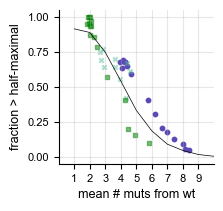

In [32]:
### plotting results with maximum number of mutated positions = 10, while scanning different temperatures
dot_size = 10
alpha_other = 0.5
fig = plt.figure(figsize=(2,2))

plt.scatter(df_coves_sampling_results_all.loc[df_coves_sampling_results_all.max_mut ==10].average_wt_hamming,
            df_coves_sampling_results_all.loc[df_coves_sampling_results_all.max_mut ==10].frac_above_thresh, 
            label='COVES, max=10', s=dot_size, c= '#5B49B6')

df_plot = df_result_esm_all.loc[df_result_esm_all.max_mut ==10]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label='esm-IF, max=10', s=dot_size, alpha=alpha_other, c='#59C09D', marker='x')

df_plot = df_mpnn_all.loc[(df_mpnn_all.max_mut ==10)]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label='proteinMPNN, max10', s=dot_size, alpha=alpha_other, c='green', marker='s')

# plot observed function
plt.plot(list_hamming_obs,list_fraction_alive_obs, c='black', label='observed', lw=0.5)
plt.xticks(list(range(1,10)),size=8)
plt.yticks([0,0.25, 0.5, 0.75, 1],size=8)

plt.xlim([0,10])
plt.ylim([-0.05,1.05])
plt.xlabel('mean # muts from wt', fontsize=9)
plt.ylabel('fraction > half-maximal', fontsize=9)
#plt.legend(loc='upper right',fontsize=9)
plt.grid(alpha=0.3)
fig.patch.set_visible(False)
#fig.tight_layout()

plt.savefig(dout + 'gfp_sample_eval_div_func_maxPos10_t_scan.svg', format='svg')

plt.show()

## plotting sample evaluation using different scan of max_pos_mutate at low temperatures

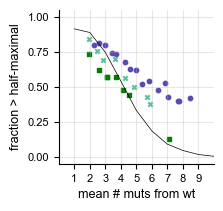

In [33]:
dot_size = 10
alpha_other = 0.5
fig = plt.figure(figsize=(2,2))

t=0.5
df_plot = df_coves_sampling_results_all.loc[df_coves_sampling_results_all.t==t]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label=f'COVES, t={t}', s=dot_size, c= '#5B49B6')

t=1.0
df_plot = df_result_esm_all.loc[df_result_esm_all.t==t]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label=f'esm, t={t}', s=dot_size, c='#59C09D', marker='x')
t=1.5   
df_plot = df_mpnn_all.loc[df_mpnn_all.t==t]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label=f'mpnn, t={t}', s=dot_size, c='green', marker='s')


# plot observed function
plt.plot(list_hamming_obs,list_fraction_alive_obs, c='black', label='observed', lw=0.5)
plt.xticks(list(range(1,10)),size=8)
plt.yticks([0,0.25, 0.5, 0.75, 1],size=8)
plt.xlim([0,10])
plt.ylim([-0.05,1.05])
plt.xlabel('mean # muts from wt', fontsize=9)
plt.ylabel('fraction > half-maximal', fontsize=9)
#plt.legend(fontsize=9)
plt.grid(alpha=0.3)
fig.patch.set_visible(False)
#fig.tight_layout()
plt.savefig(dout + 'gfp_sample_eval_div_func_lowT_scan_mutPos.svg', format='svg')
plt.show()

## plotting sample eval with max_pos15 and different temperatures

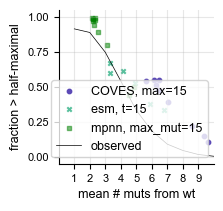

In [106]:
dot_size = 10
alpha_other = 0.5
plt.figure(figsize=(2,2))
df_plot = df_coves_sampling_results_all.loc[df_coves_sampling_results_all.max_mut ==15]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label='COVES, max=15', s=dot_size, c= '#5B49B6')

df_plot = df_result_esm_all.loc[df_result_esm_all.max_mut==15]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label=f'esm, t=15', s=dot_size, c='#59C09D', marker='x')

df_plot = df_mpnn_all.loc[df_mpnn_all.max_mut==15]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label=f'mpnn, max_mut=15', s=dot_size, c='green', marker='s', alpha=alpha_other)
# plot observed function
plt.plot(list_hamming_obs,list_fraction_alive_obs, c='black', label='observed', lw=0.5)
plt.xticks(list(range(1,10)),size=8)
plt.yticks([0,0.25, 0.5, 0.75, 1],size=8)

plt.xlim([0,10])
plt.ylim([-0.05,1.05])
plt.xlabel('mean # muts from wt', fontsize=9)
plt.ylabel('fraction > half-maximal', fontsize=9)
plt.legend(fontsize=9)
plt.grid(alpha=0.3)
fig.patch.set_visible(False)
#fig.tight_layout()
plt.savefig(dout + 'gfp_sample_eval_div_func_maxPos15_t_scan.svg', format='svg')
plt.show()